#### Teoría de Circuitos II
<img src="./logo_UTN.svg" align="right" width="150" /> 

# Filtros digitales recursivos (IIR): Introducción 
#### Dr. Ing. Mariano Llamedo Soria
Grupo de Investigación en Bioingeniería (GIBIO)


### Introducción

Este notebook acompaña y amplía las explicaciones que se han dado en clase y en [formato audiovisual](https://www.youtube.com/watch?v=D0c8uVPNtUU&list=PLlD2eDv5CIe9_QZtKGEPw5LtQRD3xaAnV&index=10).
Se tratarán los filtros digitales recursivos, o de respuesta **infinita** al impulso (IIR), como contraparte de los filtros analógicos que se estudiaron durante la primera parte de la materia [Teoría de Circuitos 2](https://sge.frba.utn.edu.ar/materias.php?cod=95-0431#marca), en la [UTN FRBA](https://www.frba.utn.edu.ar/electronica/). Anteriormente se estudiaron diferentes aproximaciones a la respuesta de un filtro ideal (*brick-wall* en inglés), como la de Butterworth, Chebyshev y Bessel. Para cada función de aproximación, se obtuvo una función matemática $T(s)$ que podía implementarse mediante un circuito electrónico analógico. 

En esta parte de la asignatura el circuito analógico será emulado mediante un algoritmo, implementado en un sistema digital a una frecuencia de muestreo $f_S$, que calculará una nueva salida cada $1/f_S$ segundos. Para que la salida del sistema digital sea equivalente a la del sistema analógico, es necesario discretizar $T(s)$ o convertirlo en  mediante la [transformada bilineal](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/filter_design/bilinear_transform.ipynb), es decir hacer un cambio de la variable continua dado por el siguiente núcleo

\begin{equation}
s = 2 \, f_S \cdot \frac{z - 1}{z + 1}
\end{equation}

luego 

\begin{equation}
T(z) = T(s) \Big\vert_{s = 2 \,f_S \cdot \frac{z - 1}{z + 1}}
\end{equation}

Es decir, dada una sección de segundo orden (SOS) analógica

\begin{equation}
T(s) = \frac{\beta_0 + \beta_1 s + \beta_2 s^2}{\alpha_0 + \alpha_1 s + \alpha_2 s^2}
\end{equation}

su equivalente digital $T(z)$ también podrá expresarse como un cociente de polinomios en $z$, aunque como hemos visto, por razones de implementación lo haremos respecto a $z^{-1}$

\begin{equation}
T(z) = \frac{(\beta_2 K^2 - \beta_1 K + \beta_0) \, z^{-2} + (2 \beta_0 - 2 \beta_2 K^2) \,  z^{-1} + (\beta_2 K^2 + \beta_1 K + \beta_0)}
{(\alpha_2 K^2 - \alpha_1 K + \alpha_0) \, z^{-2} + (2 \alpha_0 - 2 \alpha_2 K^2) \,  z^{-1} + (\alpha_2 K^2 + \alpha_1 K + \alpha_0)}
\end{equation}
donde $K = 2f_S$.

Para luego reescribir $T(z)$ en función de los coeficientes del sistema muestreado $b_m$ y $a_n$

\begin{equation}
T(z) = \frac{Y(z)}{X(z)} = \frac{ b_2 \, z^{-2} + b_1 \,  z^{-1} + b_0 }
{a_2 \, z^{-2} + a_1 \,  z^{-1} + a_0}
\end{equation}

obteniendo también una SOS como era de esperar, dado que la transformada bilineal es una transformación conforme. 

Una vez obtenida nuestra $T(z)$ de orden arbitrario, solo resta factorizar la transferencia en subsecciones de segundo orden (SOS), que de la misma manera que fue conveniente para los sistemas analógicos, lo sigue siendo para los filtros digitales, aunque por otros motivos. Por este motivo **siempre** preferiremos trabajar con una $T(z)$ factorizada en SOS. Quienes se interesen por estas cuestiones, pueden revisar la [bibliografía complementaria](https://drive.google.com/drive/u/1/folders/1Bd87h5CEfY2NmMum0U-n74j2_2Tj3y1n) de filtros digitales. Por este motivo es necesario conocer tanto la [estructura](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/recursive_filters/direct_forms.ipynb) como la forma en que nuestro paquete de software implementa las [SOS's](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/recursive_filters/cascaded_structures.ipynb)
e. En el caso de *SciPy*, cuenta con una familia de funciones donde es muy sencillo diseñar y utilizar filtros digitales implementados como SOS's, como se verá en la implementación. Sin embargo, **es muy posible** que sea necesario convertir los coeficientes para implementar los mismos filtros en otra arquitectura, dependiendo de cómo cada fabricante implementó la librería de DSP en su arquitectura digital.

Retomando la expresión de $T(z)$, posiblemente la forma más sencilla para llegar a la implementación de nuestro filtro digital sea despejando $Y(z)$ y antitransformando

\begin{equation}
Y(z) =  \frac{1}{a_0} \left( \sum_{m=0}^{M} b_m \, X(z) \, z^{-m} - \sum_{n=1}^{N} a_n \, Y(z) \, z^{-n} \right)
\end{equation}

finalmente se obtiene $y[k]$ por simple inspección sabiendo que $y[k-m] = Y(z) \, z^{-m}$

\begin{equation}
y[k] = \frac{1}{a_0} \left( \sum_{m=0}^{M} b_m \; x[k-m] - \sum_{n=1}^{N} a_n \; y[k-n] \right) 
\end{equation}

Esta ecuación nos permite conocer el valor de la salida actual, y se la conoce como *ecuación de diferencias*. Es la forma más simple de implementar cualquier filtro digital. Una limitación evidente de esta ecuación es que para órdenes elevados ($N$ apenas por encima de 5 en ciertas arquitecturas), los términos recursivos podrían arrastrar errores de [cuantización y cálculo](https://nbviewer.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/recursive_filters/quantization_of_variables.ipynb) que a pocas muestras de inicializarse, el error provocado se amplifica e **inhabilita el resultado** de $y(k)$. Esto se puede dar por oscilaciones y por saturación de la arquitectura y es tema de estudio.

Como se dijo antes, para los fines de esta materia factorizaremos $T(z)$ en SOS y utilizaremos las funciones de *SciPy* que facilitan este tipo de diseño, análisis e implementación de los filtros:

* [iirdesign](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirdesign.html#scipy.signal.iirdesign) es una función para el diseño de los filtros directamente desde la plantilla de diseño. Es una función que sirve tanto para el diseño de filtros analógicos como digitales, aunque en este contexto lo usaremos solo para el diseño digital $T(z)$.
* [sosfreqz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfreqz.html#scipy.signal.sosfreqz) será la función que utilizaremos para calcular la respuesta de módulo y fase de $T(z)$.
* [sosfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfilt.html#scipy.signal.sosfilt) servirá para utilizar el filtro, es decir producirá $Y(z)= X(z).T(z)$ 

Como se puede ver en la documentación de las funciones, e inmediatamente aquí debajo en los ejemplos, las tres están preparadas para el manejo de filtros factorizados en SOS. Se vio en clase y [en otros documentos](link a notebook iir pytc2), que el diseño a partir de los filtros analógicos como prototipo, es **poco práctico** y requiere iteraciones para ajustarse a requerimientos de plantilla estrictos, por supuesto dependiendo de la experiencia del usuario. Estos inconvenientes fueron resueltos con software **más eficiente**, como la función [iirdesign](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirdesign.html#scipy.signal.iirdesign) que es capaz de diseñar un filtro digital IIR con el mínimo orden posible, a partir de su plantilla sin ninguna iteración. Por este motivo se sugiere el uso de estas funciones como herramienta superadora para la implementación de este tipo de filtros.

Comenzamos preparando el entorno de trabajo:


In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pytc2.sistemas_lineales import plot_plantilla

fig_sz_x = 25
fig_sz_y = 10
fig_dpi = 80 # dpi

fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})


Para luego continuar con el primer ejemplo que será el diseño de un filtro pasabajo.

## Filtro pasabajas IIR

Definimos la plantilla del filtro de máxima planicidad (Butterworth), y directamente procedemos al diseño.

In [2]:
#Diseño de un pasabajos sencillo

# plantilla
fpass = 0.25 # normalizado
ripple = 0.5 # dB
fstop = 0.6  # normalizadoHz
atten = 40   # dB

sos_filter = sig.iirdesign(  wp = fpass,   # normalizado
                             ws = fstop,    # normalizado
                             gpass = ripple, # dB
                             gstop = atten,  # dB
                             ftype = 'butter',
                             output = 'sos',
                             analog = False,
                             fs = 2)



La variable *sos_filter* ya contiene la matriz de coeficientes del filtro, procedemos a analizarlo. Definimos una función de ayuda para la visualización de la respuesta en frecuencia

In [3]:
def graficar_respuesta(titulo):

    NN = 1000

    w, h_filter = sig.sosfreqz(sos_filter, worN=NN)
    
    w = w / np.pi * 1

    fig = plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    
    plt.plot(w, 20*np.log10(np.abs(h_filter)), lw=2, label='filter' )
    
    plt.title(titulo)
    plt.xlabel('Frequencia [Hz]')
    plt.ylabel('Modulo [dB]')
    plt.axis([0, 1, -60, 1 ]);
    
    plot_plantilla(fpass = fpass, ripple = ripple , fstop = fstop, attenuation = atten, fs = 2)

    plt.legend()


Utilizando la función, analizamos el resultado de nuestro diseño

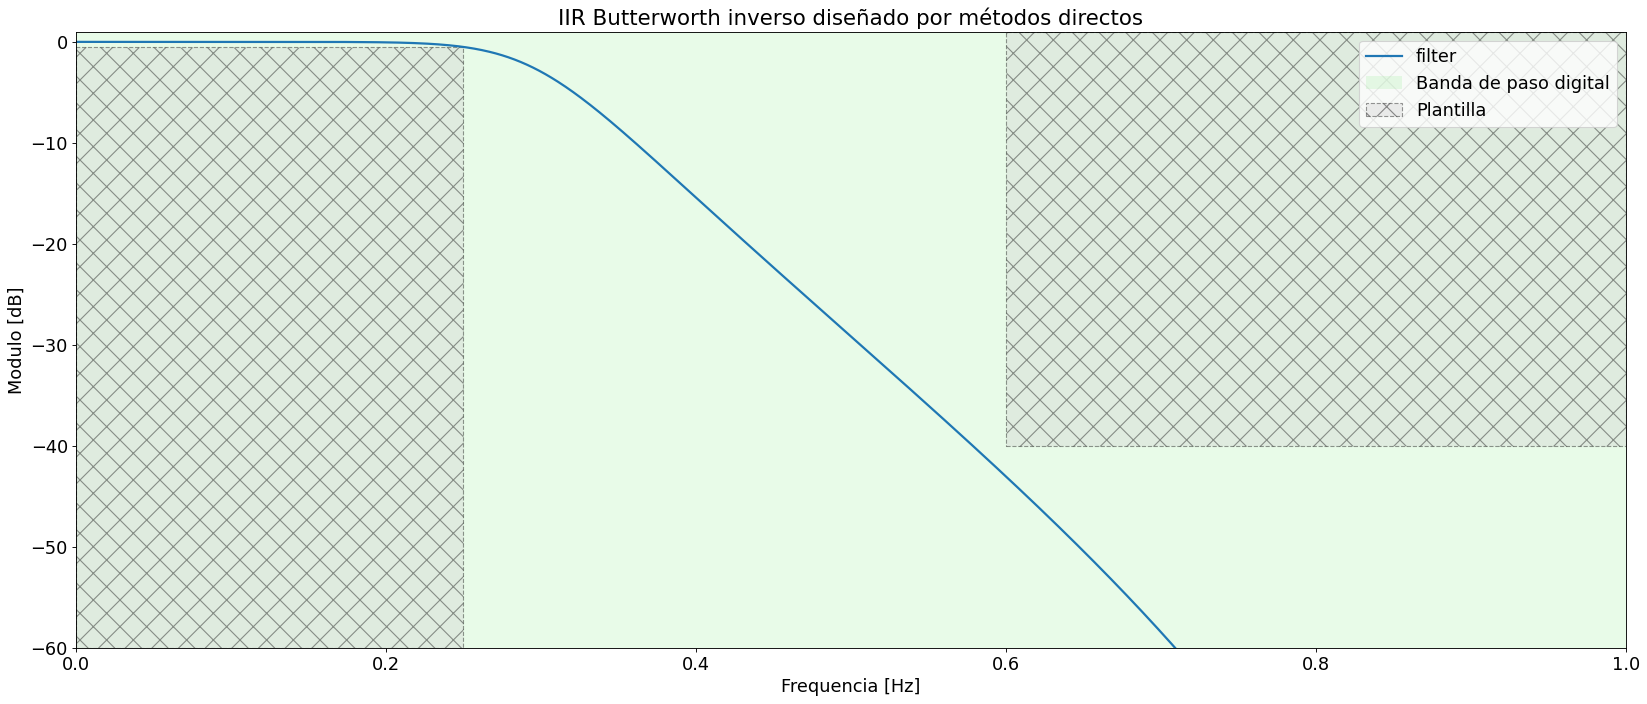

In [4]:
# grafica general
graficar_respuesta('IIR Butterworth inverso diseñado por métodos directos')

En caso de tener alguna duda por si el filtro respeta la plantilla de diseño, podemos usar la propia función de visualización para analizar más algún detalle. En este caso, la atenuación se cumple correctamente. Vemos que la curva azul está muy por debajo del vértice de la plantilla. Sin embargo, no se aprecia correctamente 

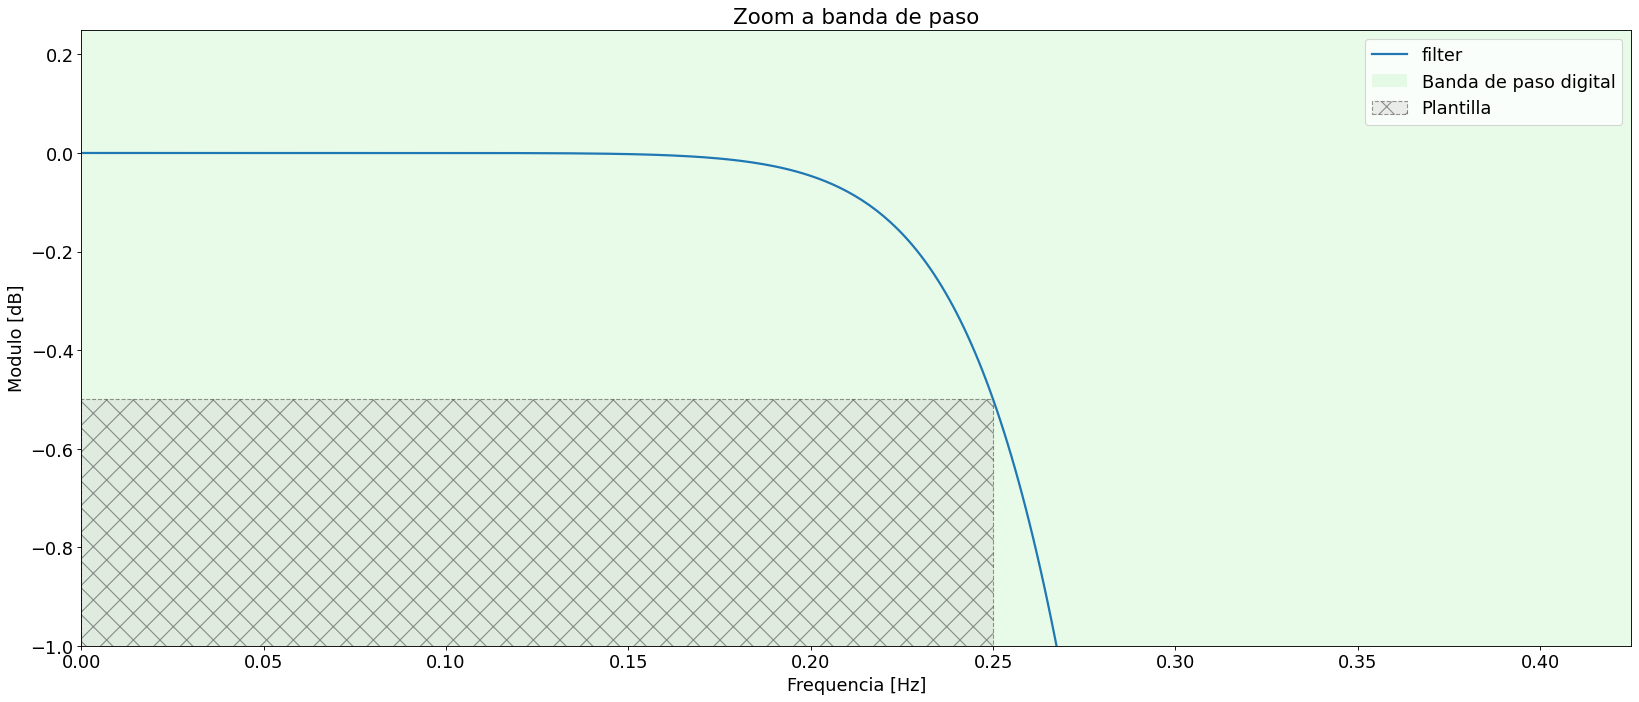

In [5]:
# zoom a banda de paso
graficar_respuesta('Zoom a banda de paso')

# editamos los límites
plt.gca().set_xlim([0, np.mean((fpass,fstop))]);
plt.gca().set_ylim([ -2*ripple, np.mean((-ripple,1)) ]);
# Muestra el gráfico
plt.show()


Podríamos pensar que el filtro es demasiado simple, veremos que pasar a diseños más complejos solo requiere reformular la plantilla de requerimientos.

## Filtro pasa-altas IIR

Se redefine entonces la plantilla para el diseño de un pasa-altas, invirtiendo *fpass* por *fstop*, y agregamos al mismo tiempo que en lugar de Butterworth, sea una aproximación de Chebyshev *equiripple* en la banda de paso.

In [6]:
#Diseño de un pasa-altas sencillo

# plantilla
fstop = 0.25 # normalizado
ripple = 0.5 # dB
fpass = 0.6  # normalizadoHz
atten = 40   # dB

sos_filter = sig.iirdesign(  wp = fpass,   # normalizado
                             ws = fstop,    # normalizado
                             gpass = ripple, # dB
                             gstop = atten,  # dB
                             ftype = 'cheby1',
                             output = 'sos',
                             analog = False,
                             fs = 2)



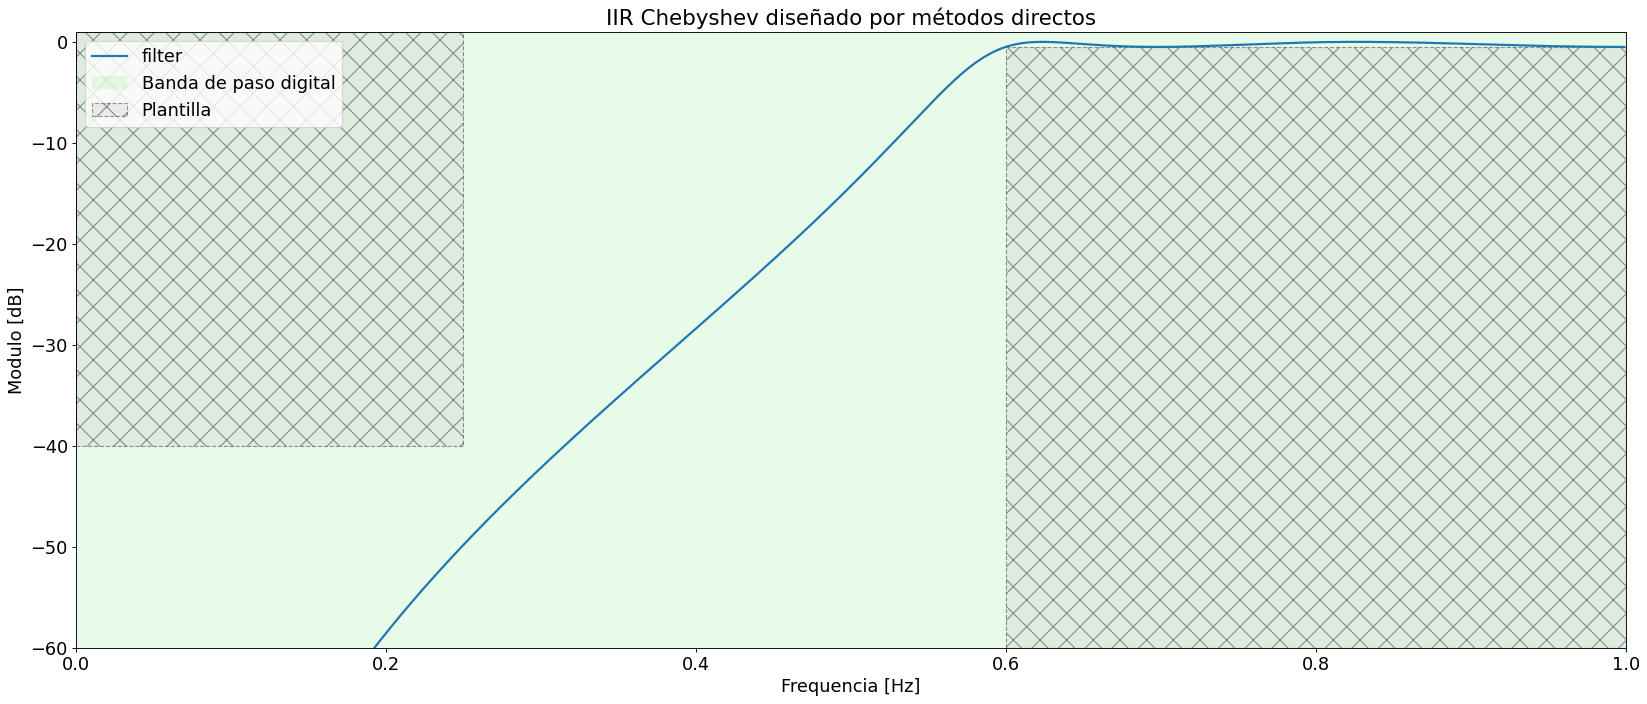

In [7]:
# grafica general
graficar_respuesta('IIR Chebyshev diseñado por métodos directos')

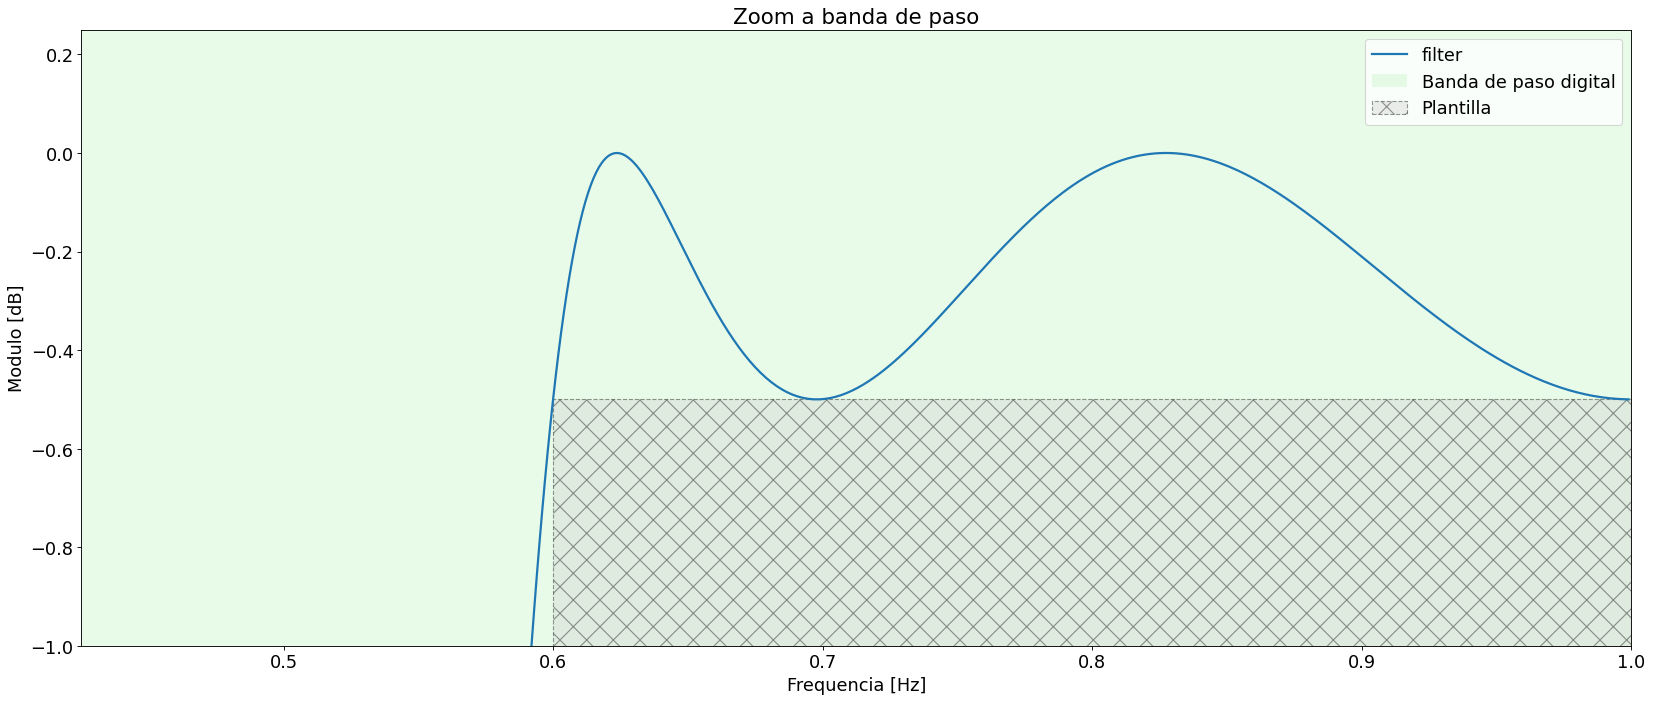

In [8]:
# zoom a banda de paso
graficar_respuesta('Zoom a banda de paso')

# editamos los límites
plt.gca().set_xlim([np.mean((fpass,fstop)), 1]);
plt.gca().set_ylim([ -2*ripple, np.mean((-ripple,1)) ]);


Sin nada de esfuerzo, el filtro está perfectamente confinado en la plantilla.

Como curiosidad, diseñamos un Chebyshev inverso, o equiripple en la banda de stop.

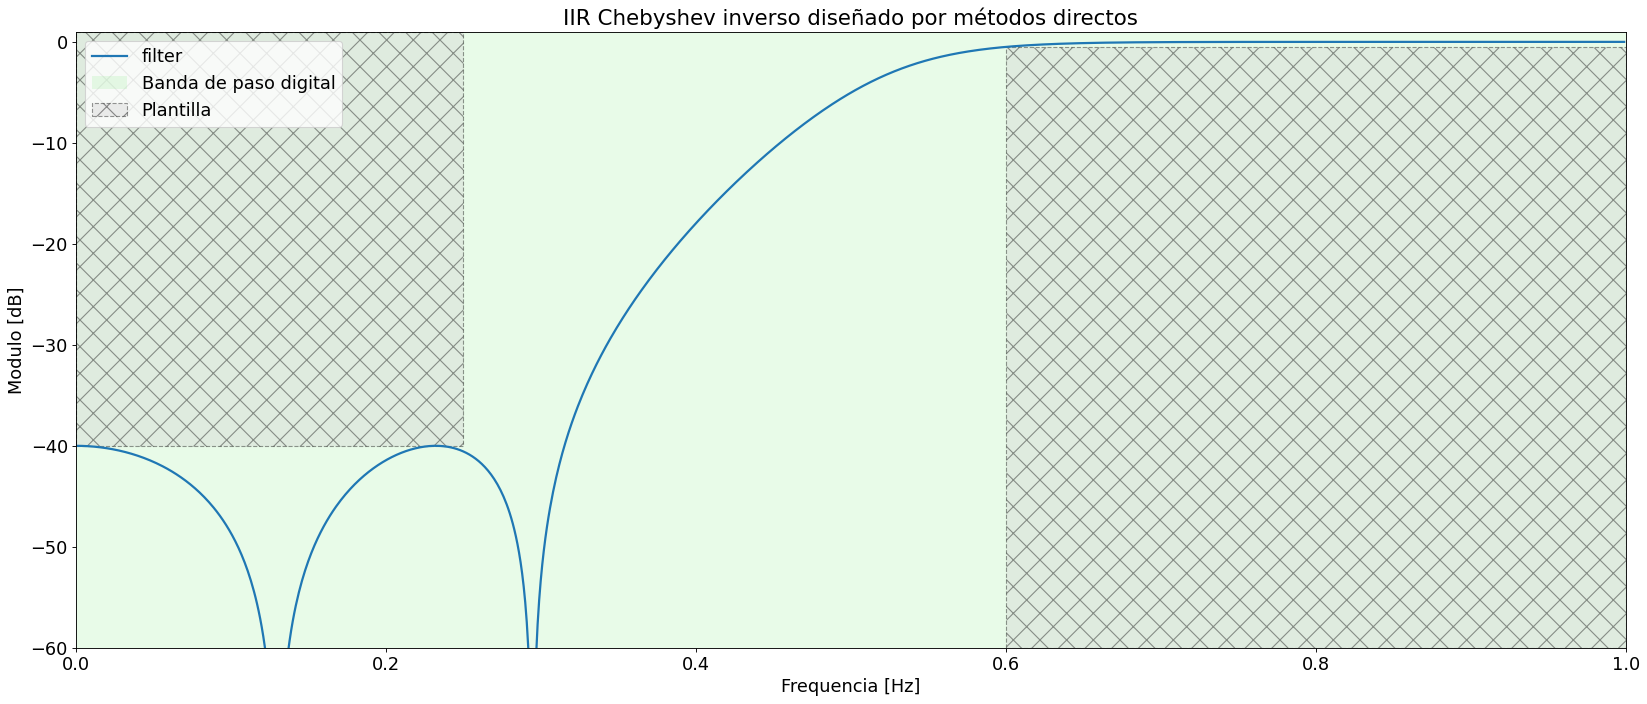

In [9]:

# cambiamos ftype = 'cheby2'
sos_filter = sig.iirdesign(  wp = fpass,   # normalizado
                             ws = fstop,    # normalizado
                             gpass = ripple, # dB
                             gstop = atten,  # dB
                             ftype = 'cheby2',
                             output = 'sos',
                             analog = False,
                             fs = 2)

# grafica general
graficar_respuesta('IIR Chebyshev inverso diseñado por métodos directos')


A esta altura, nos damos cuenta del poder de la herramienta de diseño directo y no se harán más verificaciones, salvo mostrar todo su potencial para diseñar otras transferencias.

## Otras transferencias posibles

Finalmente evaluamos transferencias pasabanda y elimina-banda, como novedad incorporamos la aproximación de Cauer o elíptica.

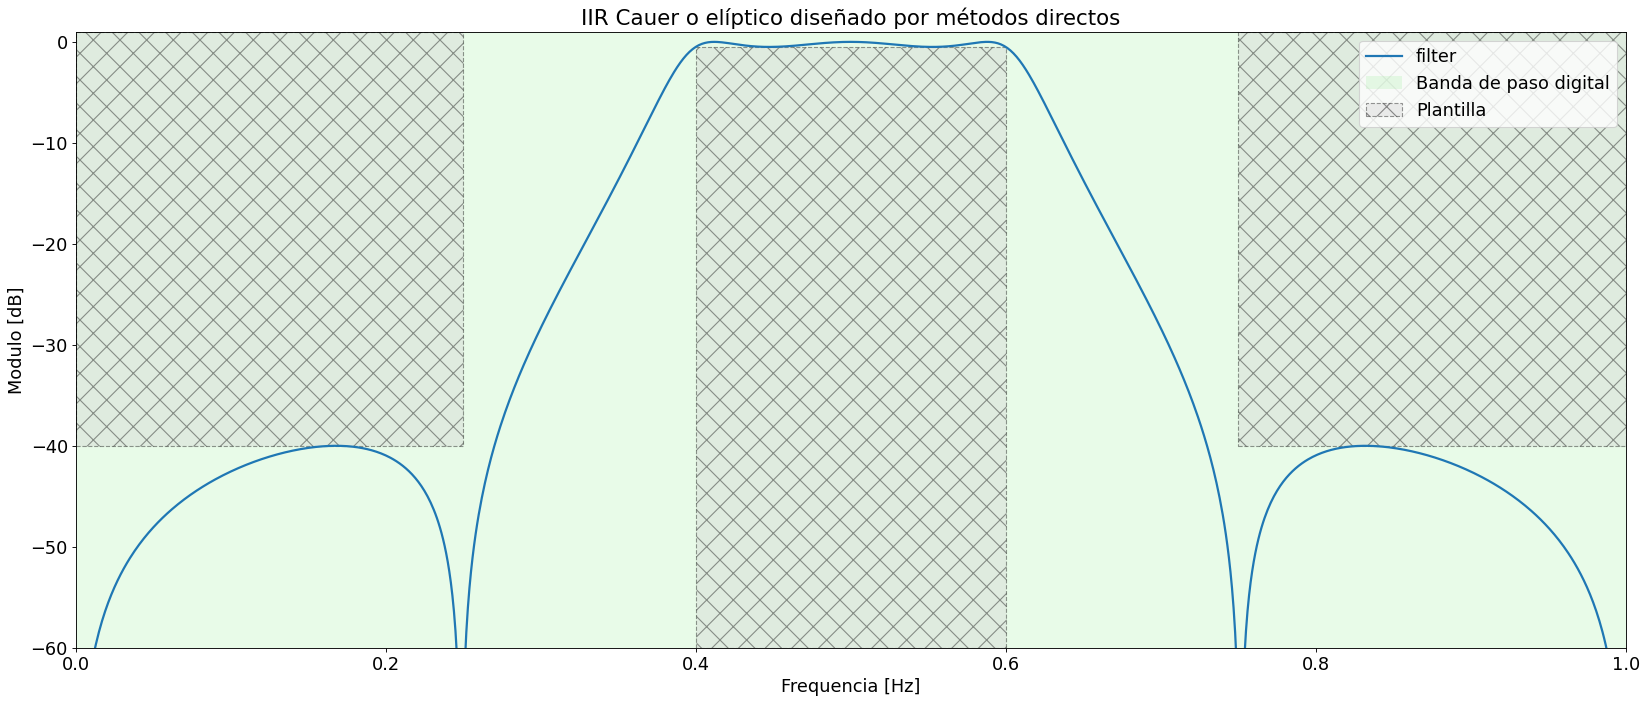

In [10]:
#Diseño de un pasabanda sencillo

# plantilla
fpass = (0.4, 0.6)   # normalizado
ripple = 0.5         # dB
fstop = (0.25, 0.75) # normalizado
attenuation = 40     # dB

sos_filter = sig.iirdesign(  wp = fpass,   # normalizado
                             ws = fstop,    # normalizado
                             gpass = ripple, # dB
                             gstop = atten,  # dB
                             ftype = 'ellip',
                             output = 'sos',
                             analog = False,
                             fs = 2)

# grafica general
graficar_respuesta('IIR Cauer o elíptico diseñado por métodos directos')


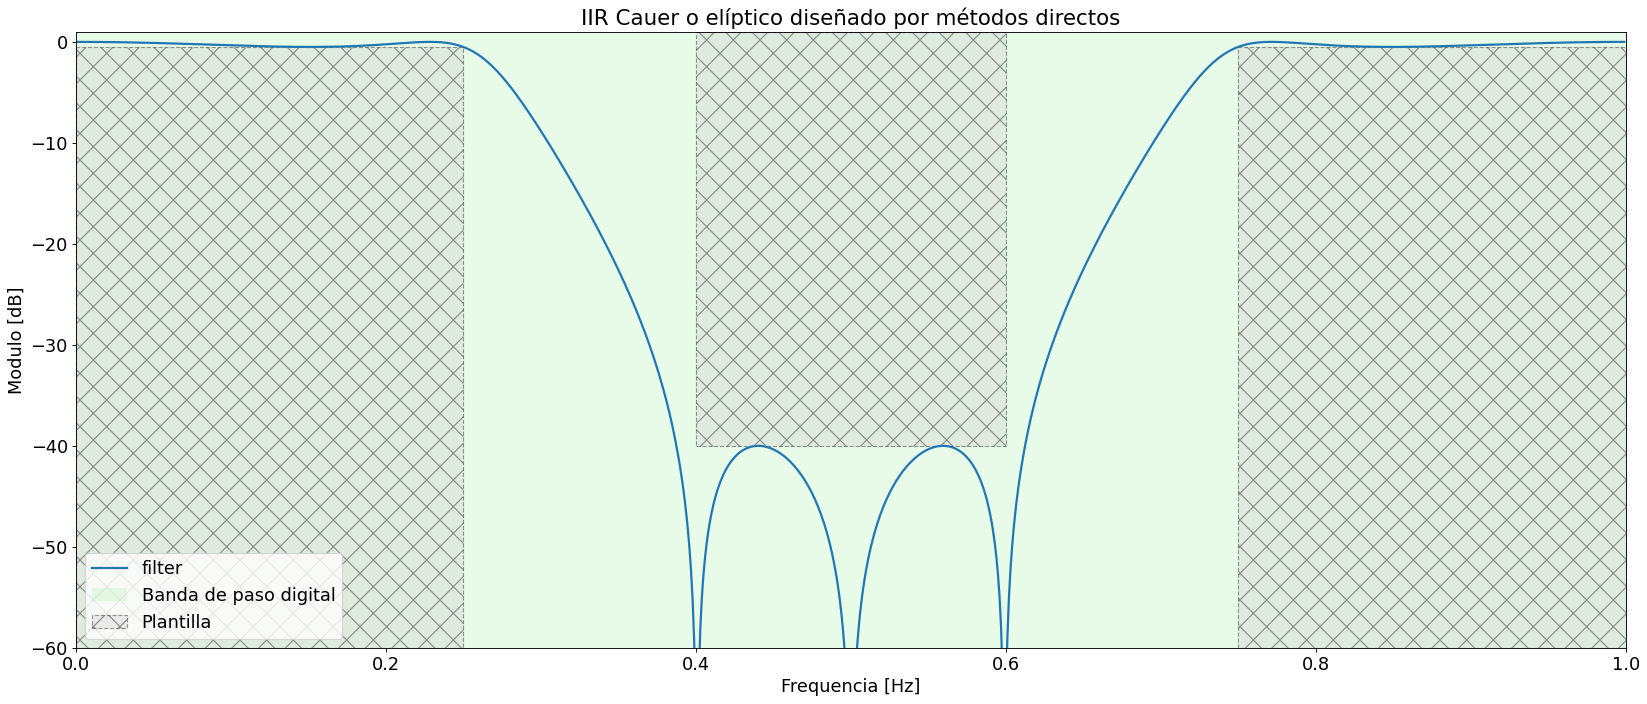

In [11]:
#Diseño de un elimina-banda sencillo

# plantilla
fstop = (0.4, 0.6)   # normalizado
ripple = 0.5         # dB
fpass = (0.25, 0.75) # normalizado
attenuation = 40     # dB

sos_filter = sig.iirdesign(  wp = fpass,   # normalizado
                             ws = fstop,    # normalizado
                             gpass = ripple, # dB
                             gstop = atten,  # dB
                             ftype = 'ellip',
                             output = 'sos',
                             analog = False,
                             fs = 2)

# grafica general
graficar_respuesta('IIR Cauer o elíptico diseñado por métodos directos')


Con estos ejemplos se pretendió mostrar el enorme potencial de las rutinas de diseño IIR. Como comentario final, decir que las mismas funciones pueden diseñar los filtros analógicos **con la misma facilidad**. Por este motivo, el mensaje final debe ser que la función de síntesis directa *iirdesign* debería ser la **función de cabecera** para el diseño **tanto de filtros analógicos como filtros digitales IIR**.


## Implementación y uso de los filtros digitales

Una vez que los filtros se diseñaron correctamente, se procede a su uso y para ello se cuenta con señales digitalizadas de electrocardiografía (ECG). Posiblemente quien lea este notebook se haya hecho alguna vez un ECG, no necesariamente por alguna patología, ya que es una práctica médica habitual. La señal de ECG tiene algunas características útiles para analizar el correcto funcionamiento de los filtros digitales:

* la información diagnóstica está en la morfología de la señal, por lo que es importante preservarla,
* tiene ancho de banda limitado
* por lo general se registra con interferencias notables, tanto de baja como de alta frecuencia.

Estas características son ideales para poner a prueba tus habilidades para el diseño de filtros digitales. Procedemos a cargar y hacer una pre-visualización de la señal de ECG registrada.

Text(0.5, 0, 'Muestras (#)')

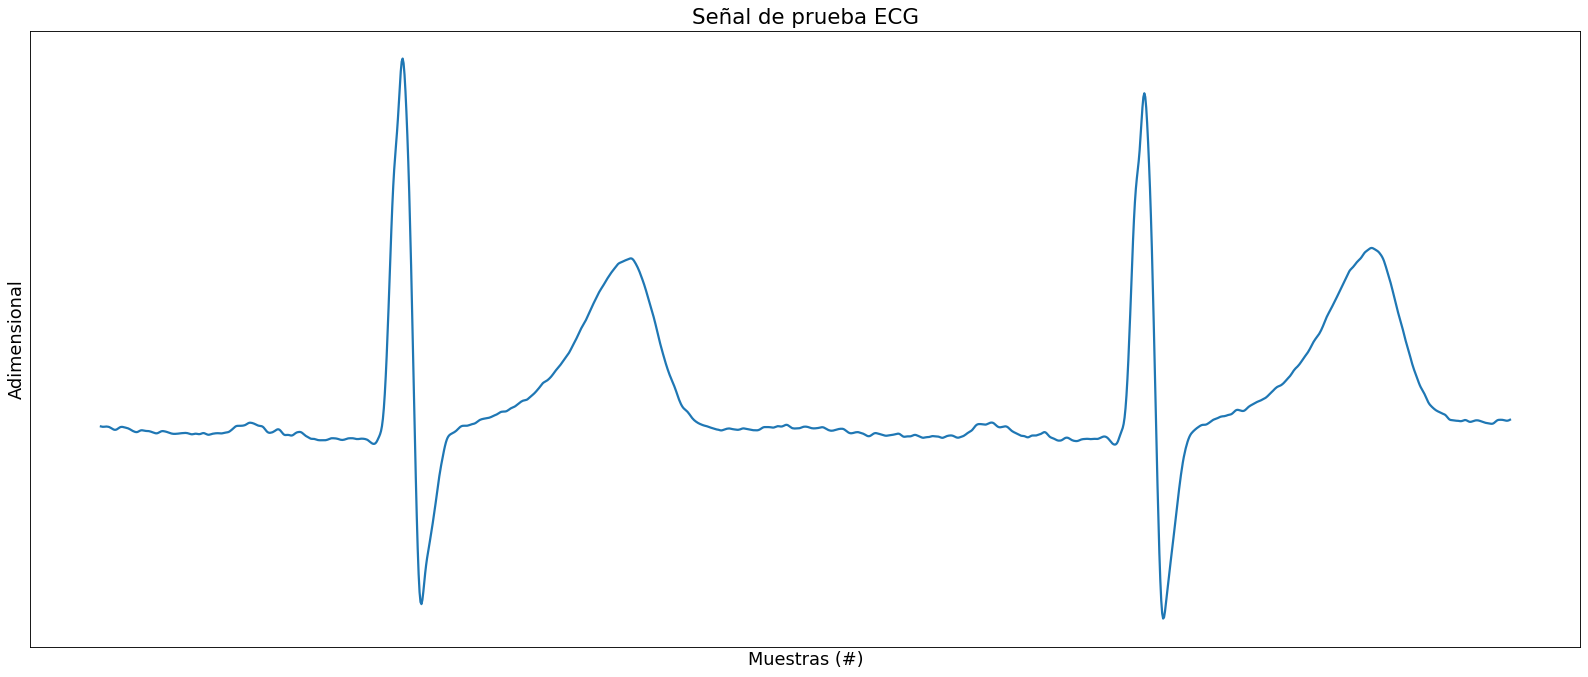

In [12]:
import scipy.io as sio

mat_struct = sio.loadmat('ecg.mat')

ECG_singlelead = mat_struct['ecg_lead']
ECG_singlelead = ECG_singlelead.flatten()
cant_muestras = len(ECG_singlelead)

fig = plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
plt.plot(ECG_singlelead[4000:5500], lw=2)
plt.gca().set_yticks([])
plt.gca().set_xticks([])
plt.title('Señal de prueba ECG')
plt.ylabel('Adimensional')
plt.xlabel('Muestras (#)')


Ahora se procede al diseño del filtro pasabanda

In [13]:
#Diseño de un pasabanda para ECG

fs = 1000 # Hz
nyq_frec = fs/2

# plantilla
fpass = np.array((0.5, 35))   # Hz
ripple = 0.5                # dB
fstop = np.array((0.1, 45)) # Hz
attenuation = 40            # dB


sos_filter = sig.iirdesign(  wp = fpass,   # normalizado
                             ws = fstop,    # normalizado
                             gpass = ripple, # dB
                             gstop = atten,  # dB
                             ftype = 'ellip',
                             output = 'sos',
                             analog = False,
                             fs = fs)

Una vez diseñado, se analizará con las mismas herramientas, aunque para ello se necesitará hacer algunos ajustes en la función de *graficar_respuesta*

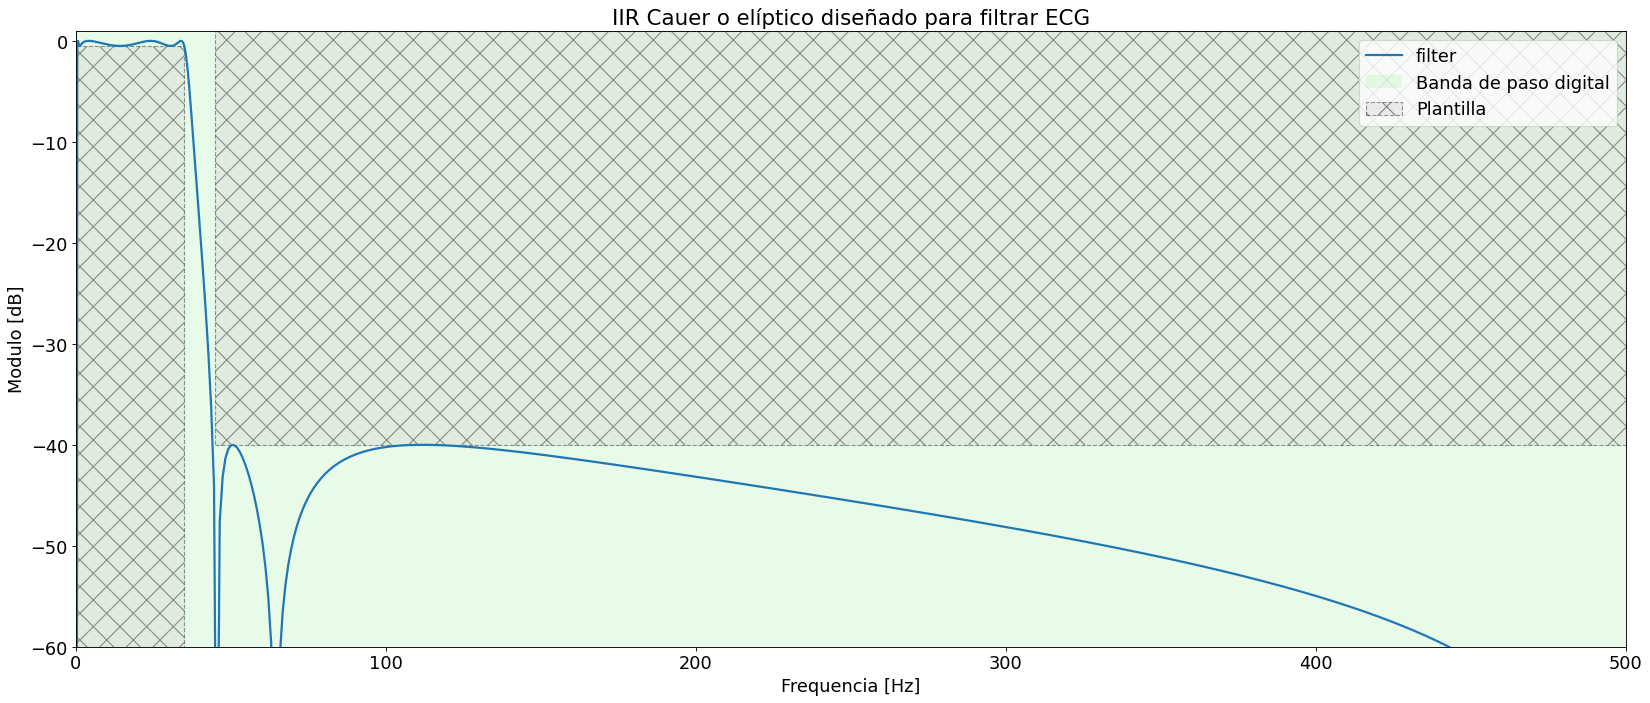

In [14]:
# redefinimos la función de graficar la respuesta para el ECG
def graficar_respuesta(titulo):

    NN = 1000

    w_rad  = np.append(np.logspace(-2, 0.8, NN//4), np.logspace(0.9, 1.6, NN//4) )
    w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, NN//2, endpoint=True) ) / nyq_frec * np.pi

    w, h_filter = sig.sosfreqz(sos_filter, worN=w_rad)
    
    w = w / np.pi * nyq_frec
    
    fig = plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    
    plt.plot(w, 20*np.log10(np.abs(h_filter)), lw=2, label='filter' )
    
    plt.title(titulo)
    plt.xlabel('Frequencia [Hz]')
    plt.ylabel('Modulo [dB]')
    plt.axis([0, fs/2, -60, 1 ]);
    
    plot_plantilla(fpass = fpass, ripple = ripple , fstop = fstop, attenuation = atten, fs = fs)

    plt.legend()


# grafica general
graficar_respuesta('IIR Cauer o elíptico diseñado para filtrar ECG')

El filtro parece estar correctamente diseñado, pero conviene revisarlo en más detalle. Nos centramos en la baja frecuencia de la plantilla para corroborar que se haya respetado la plantilla

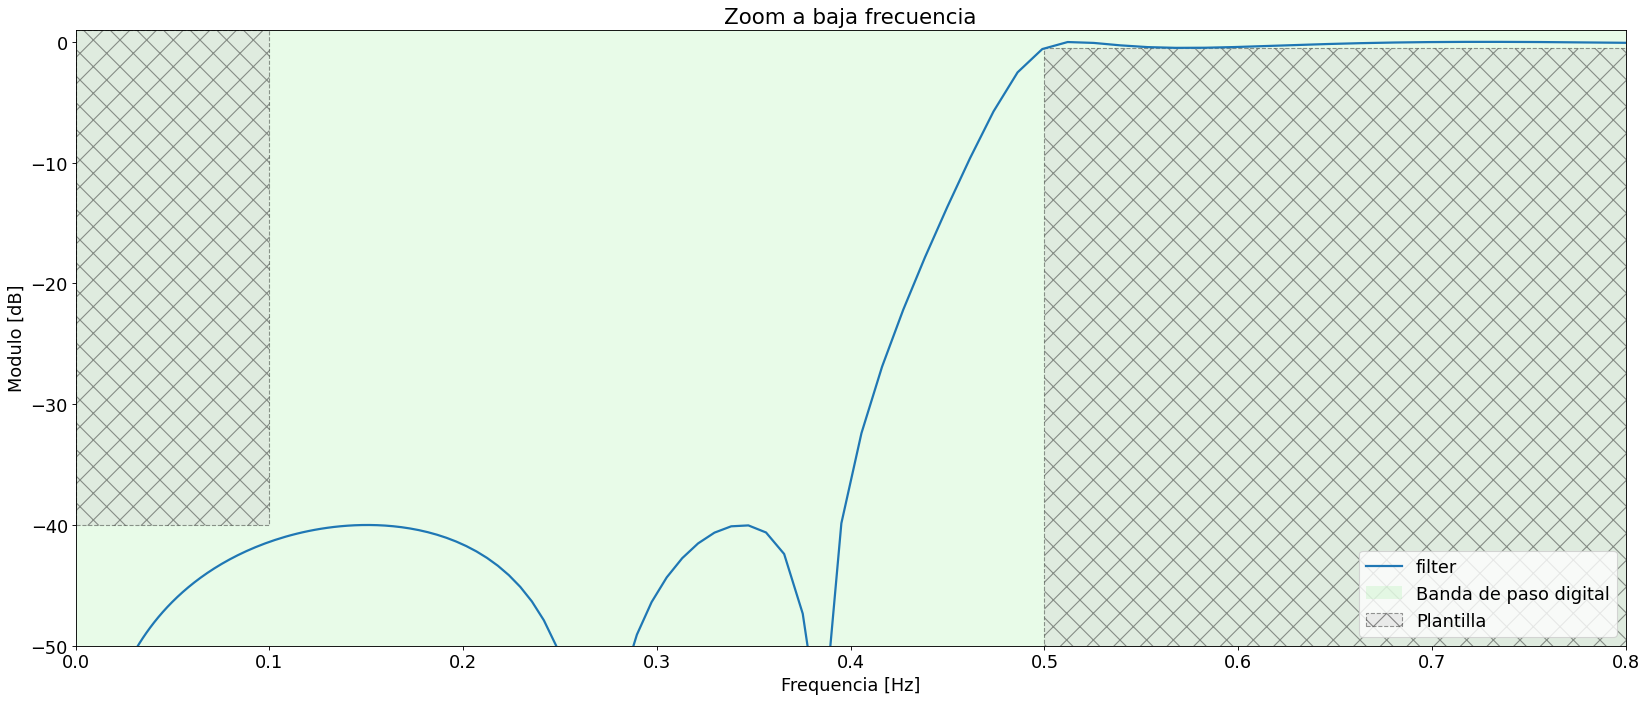

In [15]:

# zoom a banda de paso
graficar_respuesta('Zoom a baja frecuencia')

# editamos los límites
plt.gca().set_xlim([0, fpass[0] + np.mean((fpass[0],fstop[0]))]);
plt.gca().set_ylim([ -1.25*attenuation, 1 ]);


Se ve claramente que la transición de la plantilla en alta frecuencia es mucho más exigente, razón por la cual el diseño parece estar muy holgado en baja frecuencia. Para los fines de esta demostración, el filtro digital es adecuado para aplicarlo a la señal de ECG.

Se procede a utilizarlo

In [16]:
ECG_filtrado = sig.sosfilt(sos_filter, ECG_singlelead)

Ahora ya se puede analizar la señal de salida. Se analiza primero zonas de alta contaminación

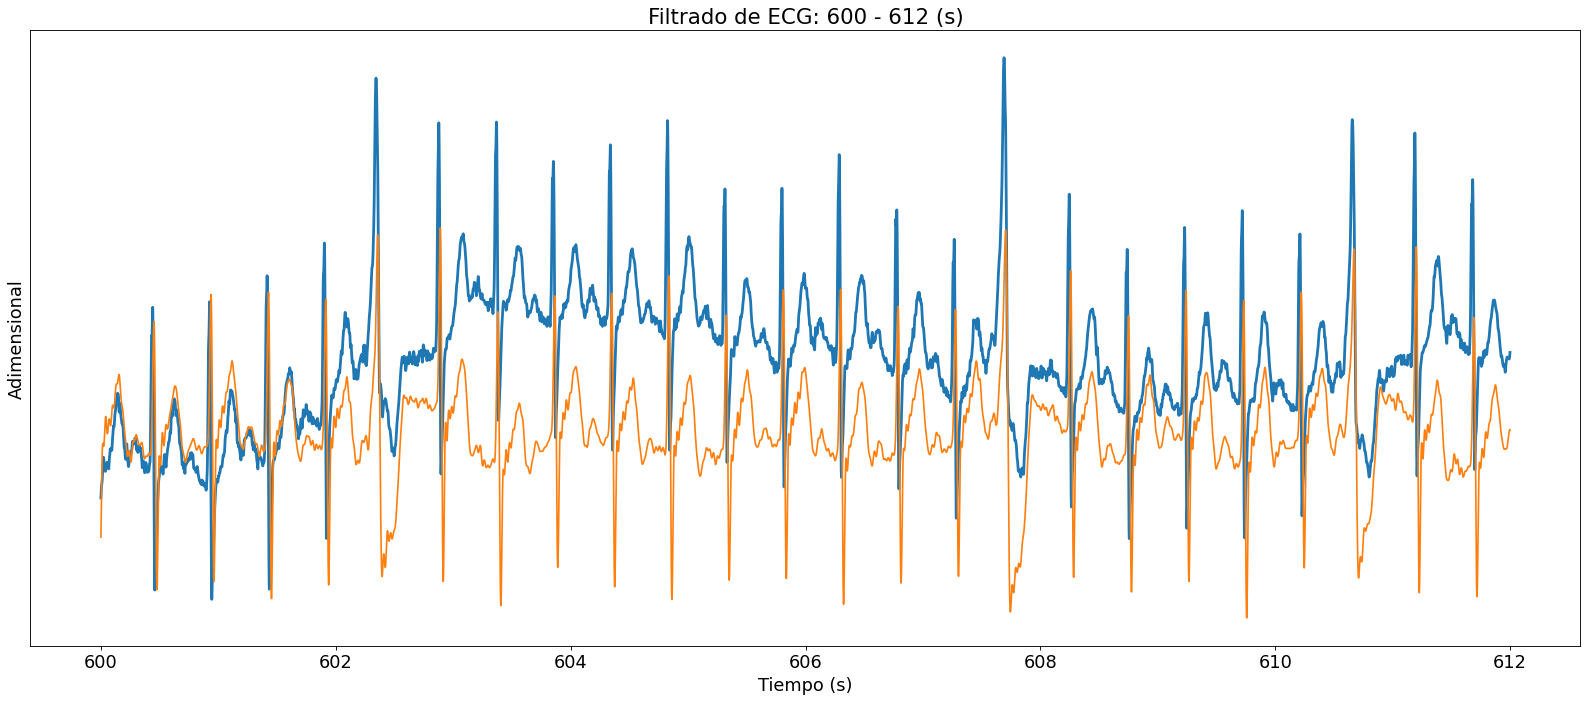

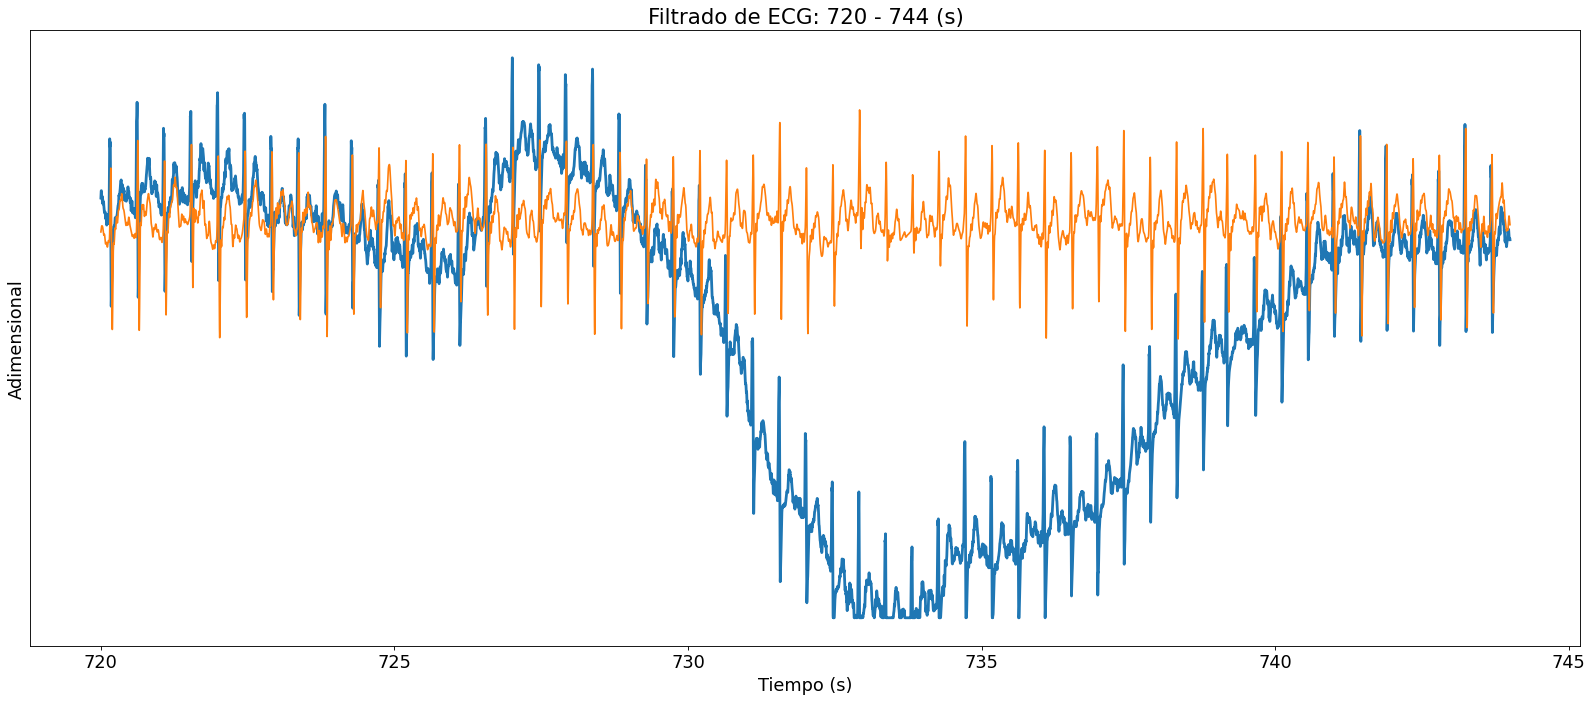

In [17]:
# areas con alta contaminación
regs_interes = ( 
        np.array([10, 10.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        )

def mostrar_resultados_ECG():
    for ii in regs_interes:
    
        zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
        fig = plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
        plt.plot(zoom_region/fs, ECG_singlelead[zoom_region], label='original', linewidth=2.5)
        plt.plot(zoom_region/fs, ECG_filtrado[zoom_region], label='filtrada', linewidth=1.5)
        plt.gca().set_yticks([])
        plt.title('Filtrado de ECG: {:3.0f} - {:3.0f} (s)'.format(ii[0]/fs, ii[1]/fs) )
        plt.ylabel('Adimensional')
        plt.xlabel('Tiempo (s)')

# visualizamos los resultados
mostrar_resultados_ECG()

Al analizar el efecto del filtrado, observamos que la señal original de ECG (en azul) posee contaminación de baja frecuencia en algunas zonas del registro. Como se observa, el filtro diseñado remueve los movimientos de baja frecuencia correctamente.

Ahora analizaremos cómo se comporta el filtro en aquellos tramos donde no hay contaminación. Desde luego nos interesará que la señal de ECG no haya sido alterada en su morfología, debido a que esto podría imposibilitar su uso como método de diagnóstico cardiológico. 

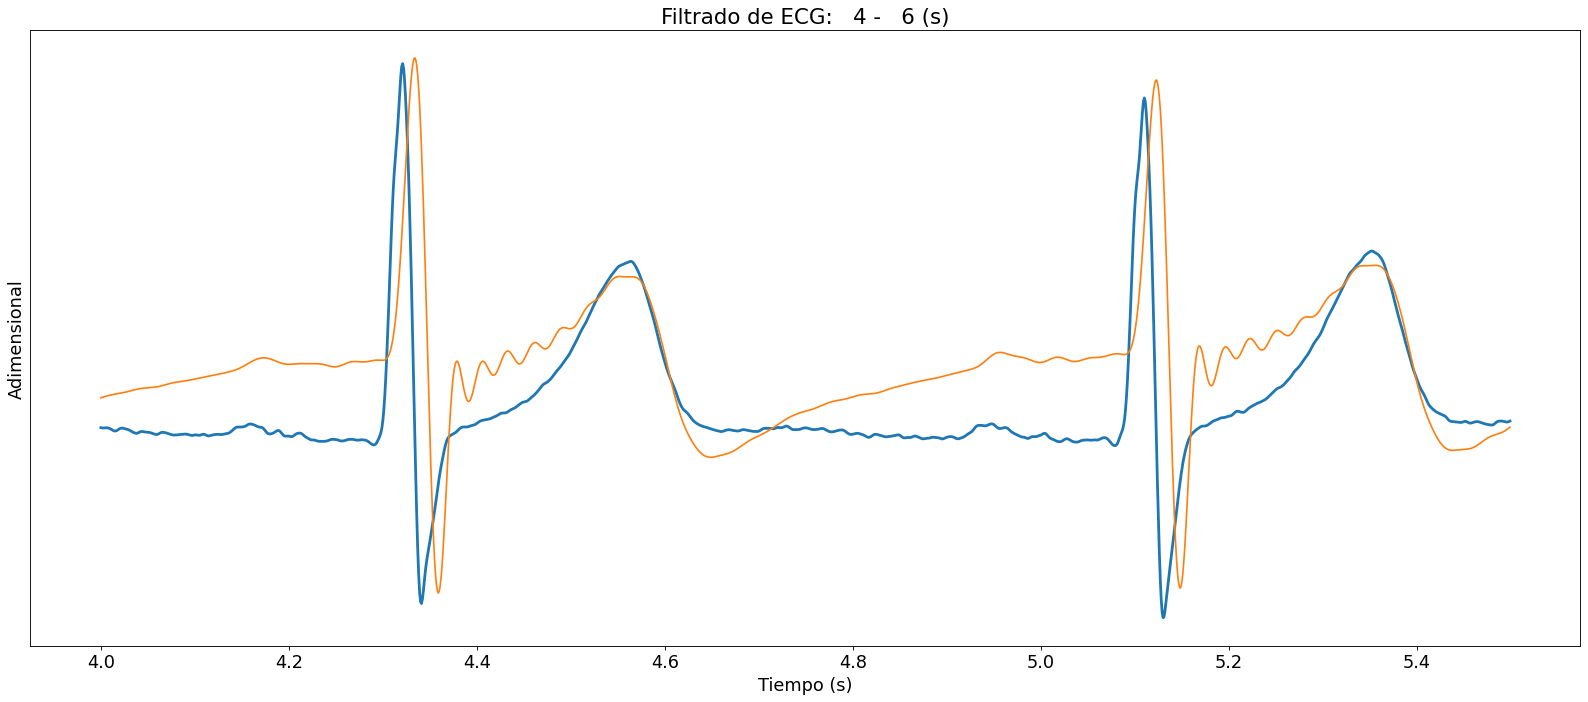

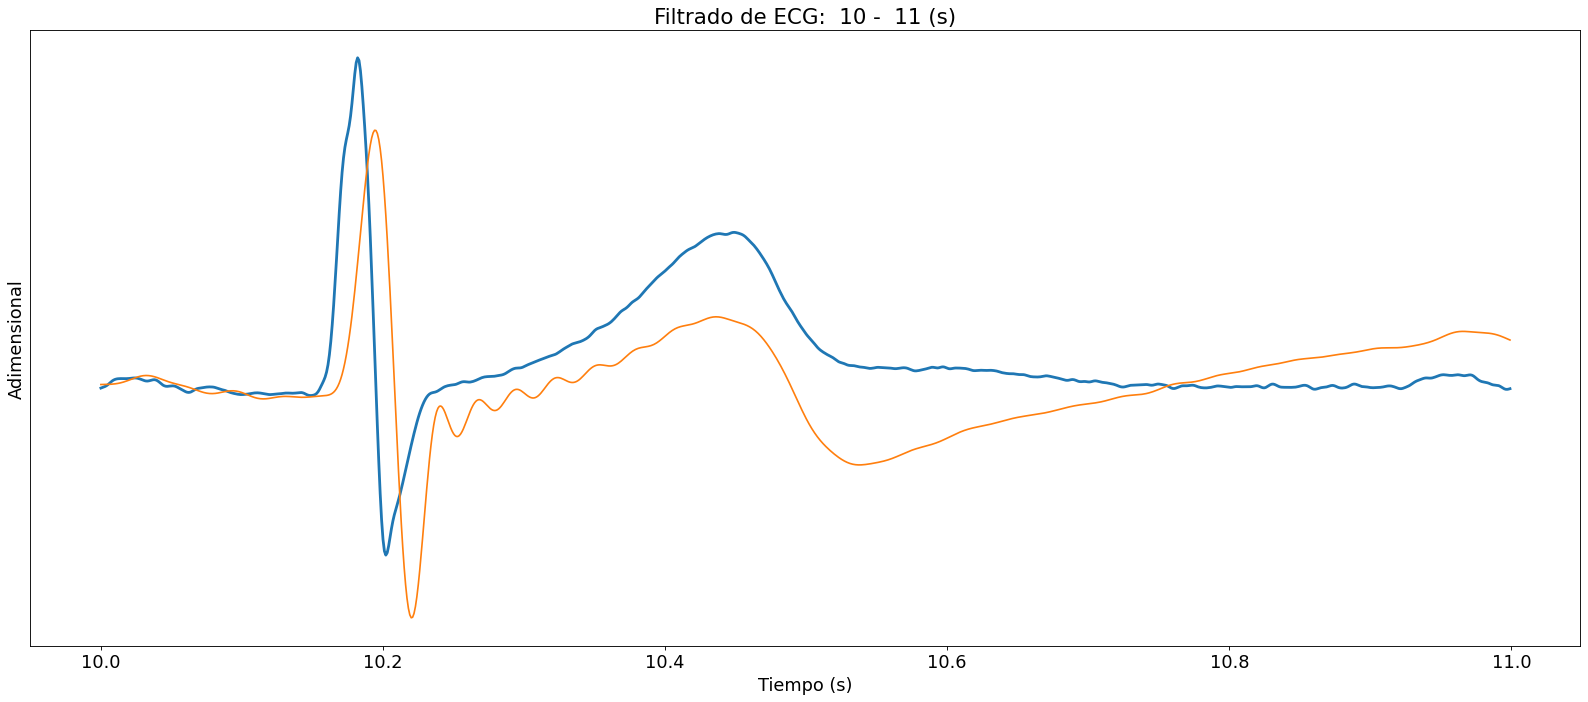

In [18]:
# areas con alta contaminación
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

mostrar_resultados_ECG()

Como se observa, la señal de ECG ha sido alterada en su morfología. Tanto el complejo de ondas QRS, es decir las primeras deflecciones rápidas de mayor energía (relacionadas con la contracción muscular), como la onda T, la segunda onda positiva de mayor duración (relacionada con la relajación muscular), han sido distorsionadas. También se observan otros artefactos ocasionados por el filtrado lineal, como oscilaciones que no estaban presentes en el ECG original (luego del complejo QRS). Estas observaciones dan cuenta que estos filtros **NO** son adecuados para el filtrado de ECG y es necesario su rediseño. 

Se sugiere a quienes tengan interés, analizar las posibles fuentes de distorsión:

* Linealidad de la respuesta de fase del filtro. En este documento, no analizamos en ningún momento la respuesta de fase, ya que sabemos del diseño de filtros analógicos que la respuesta de fase será poco lineal. Los filtros IIR, al igual que los analógicos pueden introducir distorsión de fase, especialmente aquellos que tengan singularidades con factores de selectividad Q elevados.
* Oscilaciones en la respuesta temporal. Aquellos filtros que tengan respuestas al impulso demasiado oscilatorias, tenderán a repetir dicho comportamiento en sus salidas cuando la señal de entrada se asimile a una delta, o tenga un soporte temporal muy corto. Esto se puede observar al finalizar el complejo QRS, como el filtro introduce las oscilaciones propias de su respuesta temporal.

## Conclusiones y resumen

En este documento se presentaron funciones para la síntesis directa, el análisis de la respuesta en frecuencia y la implementación de filtros digitales recursivos. En todos los casos, las funciones de diseño permiten obtener filtros que satisfacen sin problemas los requerimientos de una plantilla de atenuación. La implementación del filtro se probó en una señal de ECG, donde se analizó tanto la efectividad del diseño en su banda de atenuación, y la falta de distorsión en la banda de paso. Lamentablemente el filtro no fue lo suficientemente inocuo en su banda de paso como para poder implementarse en un dispositivo de diagnóstico, dejando a cargo de quien pudiera tener interés, [profundizar](link a prueba esfuerzo) en dichas problemáticas.
